# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [56]:
# Python Standard Library
# -----------------------
pass

In [57]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [58]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [59]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [60]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [61]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [62]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [63]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

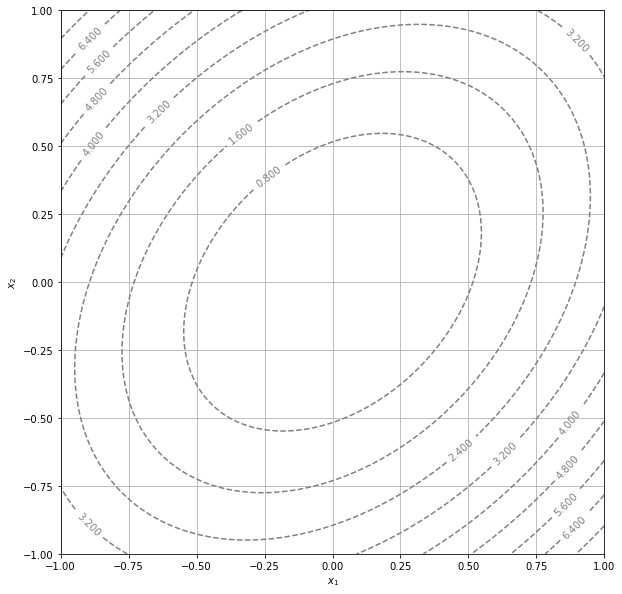

In [64]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [65]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

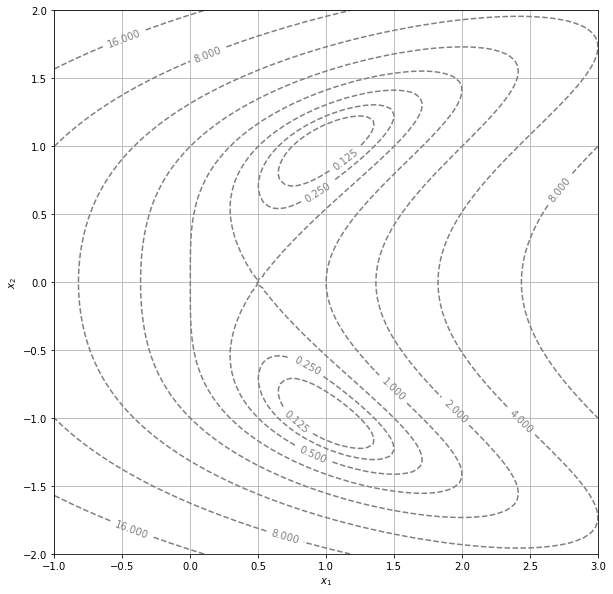

In [66]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [67]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

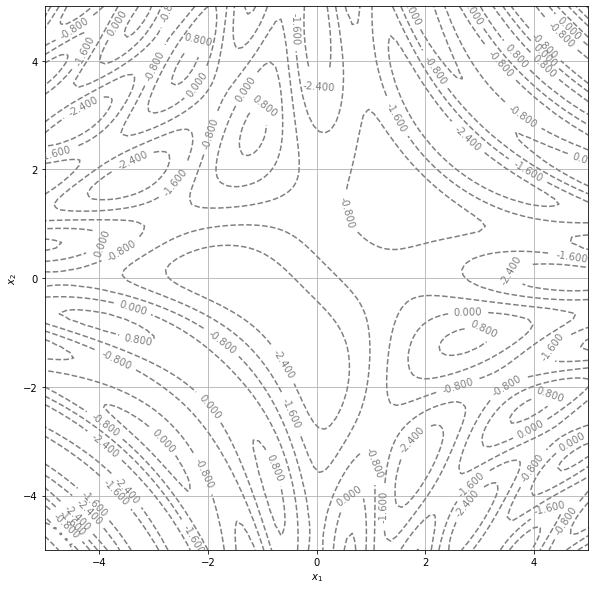

In [68]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

**_Réponse 1_**

$f$ est continue de $\mathbb{R^2}$ dans $\mathbb{R}$ et diverge vers +$\infty$ lorsque $\|(x_1,x_2)\| \to +\infty$, donc on peut montrer que $f$ admet un minumum $c_0$. 

Deux cas de figures se présentent:

1. 
Si $c<c_0$, alors l'ensemble de niveau $c$ de $f$ est vide.
2.
Sinon, par continuité de $f$,
$$
\forall c>c_0, \exists (x_1,x_2)\in\mathbb{R^2} / f((x_1,x_2))=c
$$

Donc l'ensemble de niveau $c$ de $f$ est non vide.


Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

**_Réponse 2_**

$$
\nabla f(x_0)=(\partial_1f(x_0),\partial_2f(x_0))
$$

On pose $u=(\frac{\partial_2f(x_0)}{||\nabla f(x_0)||},-\frac{\partial_1f(x_0)}{||\nabla f(x_0)||})$ le vecteur normé représentant la rotation du plan d'angle $-\frac{\pi}{2}$ de $\nabla f(x_0)$. 

Alors $p(x_1,x_2) = <u,x-x_0>$ avec $x=(x_1,x_2)$

On peut également voir $p(x_1,x_2)$ comme le déterminant de la famille $(x-x_0, \frac{\nabla f(x_0)}{||\nabla f(x_0)||})$.

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

**_Réponse 3_**


On définit la fonction 
$$
g:((x_1,x_2),t)\in\mathbb{R^2}\times\mathbb{R}\mapsto(f(x_1,x_2)-c,t - p(x_1,x_2))\in\mathbb{R^2}
$$ 

On cherche à appliquer le théorème des fonctions implicites. \
$f$ est par hypothèse continûment différentiable, et on a de manière immédiate que $p$ est également continûment différentiable. \
On veut montrer que $\partial_xg$ est inversible. On note $J(x_1,x_2)$ la jacobienne de $g$ calculée pour $t$ paramètre fixé. 

$$
det(J(x_1,x_2))=\begin{bmatrix}\frac{\partial g_1(x_1,x_2)}{\partial x_1} & \frac{\partial g_1(x_1,x_2)}{\partial x_2} \\ \frac{\partial g_2(x_1,x_2)}{\partial x_1} & \frac{\partial g_2(x_1,x_2)}{\partial x_2}\end{bmatrix}
$$ 
\
\
$$det(J(x_1,x_2))=\begin{bmatrix}\frac{\partial f(x_1,x_2)}{\partial x_1} & \frac{\partial f(x_1,x_2)}{\partial x_2} \\ -\frac{1}{||\nabla f(x_0)||}\frac{\partial f(x_0)}{\partial x_2} & \frac{1}{||\nabla f(x_0)||}\frac{\partial f(x_0)}{\partial x_1}\end{bmatrix}$$
\
D'où $$det(J(x_0))=\frac{1}{||\nabla f(x_0)||}((\partial_1f(x_0))^2+(\partial_2f(x_0))^2)=||\nabla f(x_0)||\ne0$$ par hypothèse. \
Ainsi par continuité de $det$, $J$ est inversible sur un voisinage $U$ de $x_0$. Donc $\partial_xg$ est inversible sur $U$. \
D'où, par le théorème des fonctions implicites, l'existence (et l'unicité) de la fonction $\gamma$ permettant de paramétrer la ligne de niveau $f(x_1,x_2)=c$ au voisinage de $x_0$.

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

**_Réponse 4_**

On a d'après le théorème des fonctions implicites: \
$$d\gamma(t)=-(\partial_xg)^{-1}\omicron \partial_tg$$ \
De plus $$\partial_tg(x,t)=\begin{pmatrix}0\\1\end{pmatrix}\ne0$$ \
Or d'après la question précédente, $(\partial_xg)^{-1}$ est inversible et linéaire. D'où $d\gamma(t):h\mapsto\gamma'(t).h$ est non nulle, ce qui implique $\gamma'(t)\ne0$.

Ensuite, par différenciation en chaîne:
$$(f\omicron\gamma)'(t)=\gamma_1'(t)\partial_1f(\gamma(t))+\gamma_2'(t)\partial_2f(\gamma(t))$$ \
$$(f\omicron\gamma)'(t)=\gamma'(t).\nabla f(\gamma(t))$$ \
Or pour tout t $\in ]-\epsilon,\epsilon[,(f\omicron\gamma)(t)=c$ est constante. \
Donc $\gamma'(t)$ est bien orthogonal à $\nabla f(\gamma(t))$ sur cet intervalle.

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [82]:
N = 100
eps = 10e-5

La condition de la convergence de la fonction de Newton en moins de 100 itérations exige que l'epsilon soit suffiasamment grand, tout en permettant une précision convenable. La valeur de eps choisie semble un bon compromis entre ces deux contraintes.

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [83]:
def Newton(F, x0:"point de départ", y0, eps, N):
    J_F=J(F)
    for i in range(N):
        M=np.array([F(x0,y0)[0],F(x0,y0)[1]])
        Jac=J_F(x0,y0)
        J1=np.linalg.inv(Jac)
        [x,y]=[x0,y0]-J1 @ M.T                                   #x_k+1 = x_k - f(x_k)/f'(x_k)
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

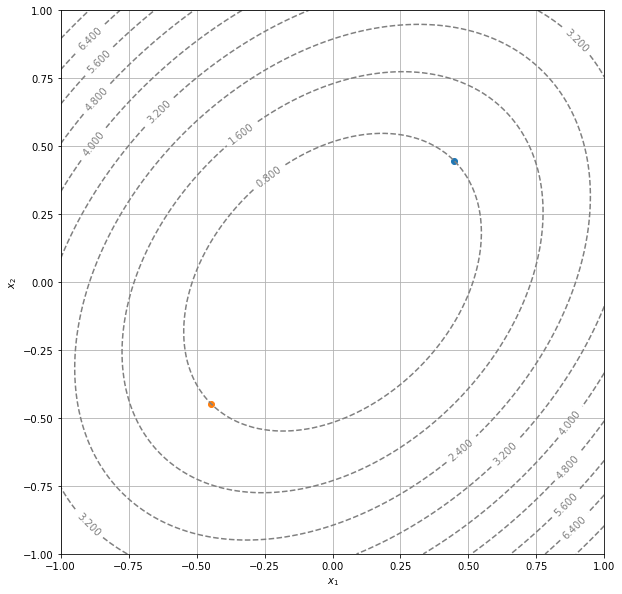

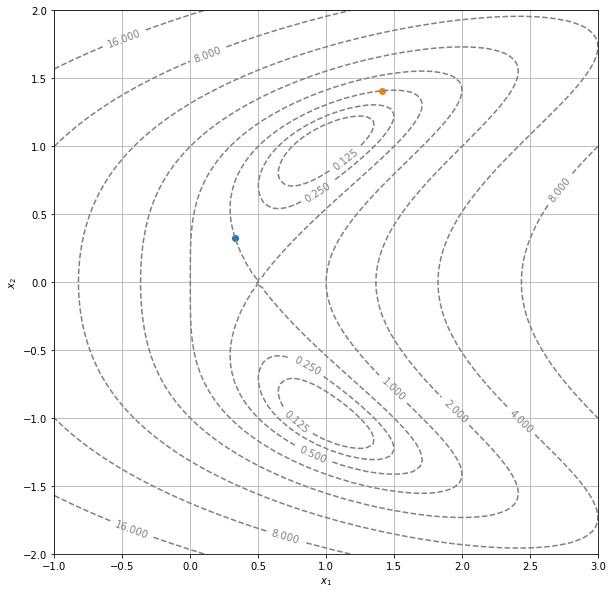

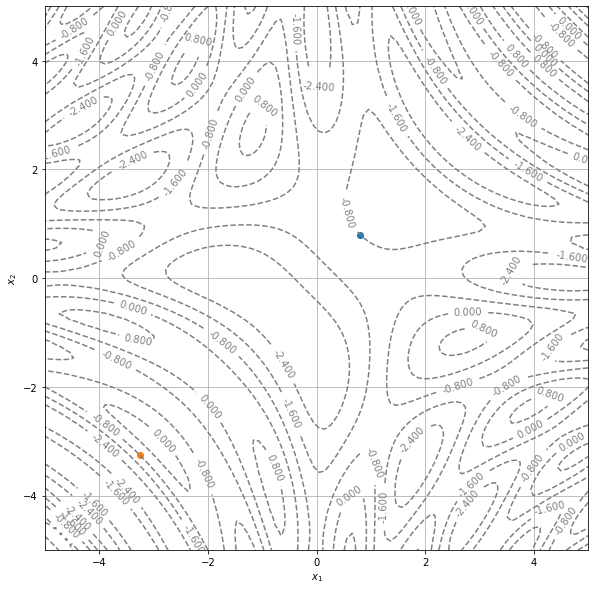

(0.328140248960982, 0.328140248960982)

In [100]:
def display(f):
    if f==f1:
        return display_contour(f1, x=np.linspace(-1.0, 1.0, 100), y=np.linspace(-1.0, 1.0, 100), levels=10)
    elif f==f2:
        return display_contour(f2, x=np.linspace(-1.0, 3.0, 100), y=np.linspace(-2.0, 2.0, 100), levels=[2**i for i in range(-3, 8)])
    elif f==f3:
        return display_contour(f3, x=np.linspace(-5.0, 5.0, 100), y=np.linspace(-5.0, 5.0, 100), levels=5)

L=[[0.8,0.8],[-0.8,-1.0]]
M=[[1.0,0.8],[1.2,1.2]]
Ñ=[[1.0,0.8],[-0.8,-1.0]]

(x0,y0)=(0.4536727413403853, -0.13811376171157663)
(x1,y1)=(0.23354250476818286, 0.34863645802015003)
(x11,y11)=(0.3636440623958305, 0.2551512761115151)
(x2,y2)=(0.15050872256557876, 0.2600740174132777)
delta=0.1

def gi(f,x,y,c:"ligne de niveau"):
    def gi_new(x,y):
        z1 = f(x,y)-c
        z2 = x-y                               #La condition x=y
        return np.array([z1,z2])
    return gi_new 

def graph_point(g,f,L): 
    display(f)
    for e in L:                           #afficher une succession de points avec des points initiaux differents
        x,y=Newton(g,e[0],e[1],eps,N)   
        plt.scatter([x],[y])
    plt.show()
    
graph_point(gi(f1,x0,y0,0.8),f1 ,L)
graph_point(gi(f2,x1,y1,0.5), f2, M)
graph_point(gi(f3,x2,y2,-0.8), f3, Ñ)


### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

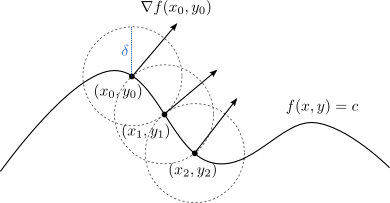

In [103]:
def g_f(f:"fonction a etudier",x0:"point solution",y0,delta):
    def g_new(x,y):
        return np.array([f(x,y)-f(x0,y0), ((x-x0)**2+(y-y0)**2)-delta**2])   #Condition de solution à une distance delta
    return g_new

def u (f,x,y):                                                      #Vecteur directeur à droite
    gradf=grad(f)
    Norm=np.linalg.norm(gradf(x,y))
    return -gradf(x,y)[1]/Norm, gradf(x,y)[0]/Norm


def level_curve(f, x, y, delta, Nb_pt, eps):
    L=[x]
    M=[y]
    for i in range (Nb_pt-1):
        g_new=g_f(f,L[-1],M[-1],delta)
        uf = u(f,L[-1],M[-1])
        l,m=Newton(g_new, L[-1]+delta*uf[0], M[-1]+delta*uf[1], eps, N)  #On itère Newton en prenant comme point initial  
        M.append(m)                                                      #le point solution légèrement décalé dans la direction
        L.append(l)                                                      #du vecteur directeur
    return np.array([L,M])


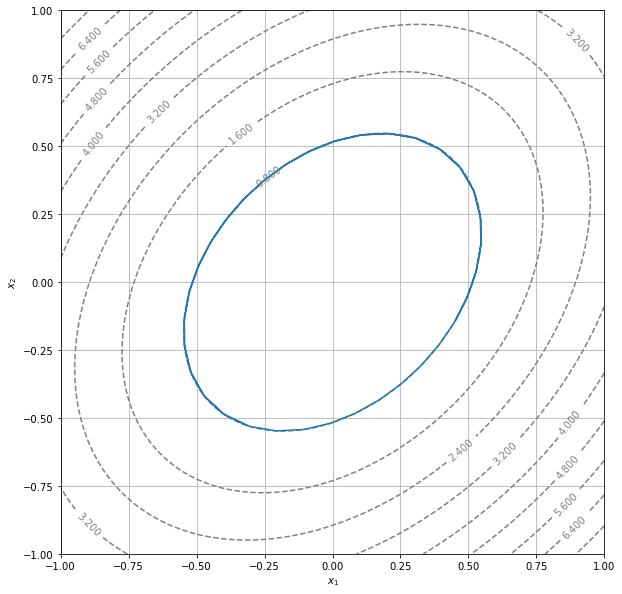

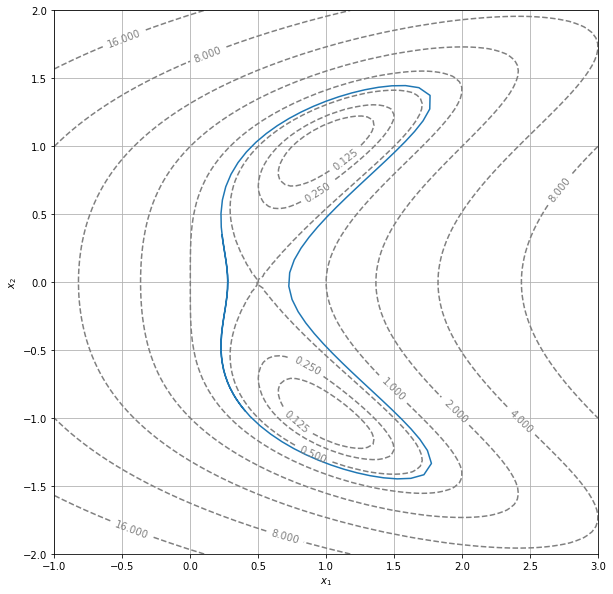

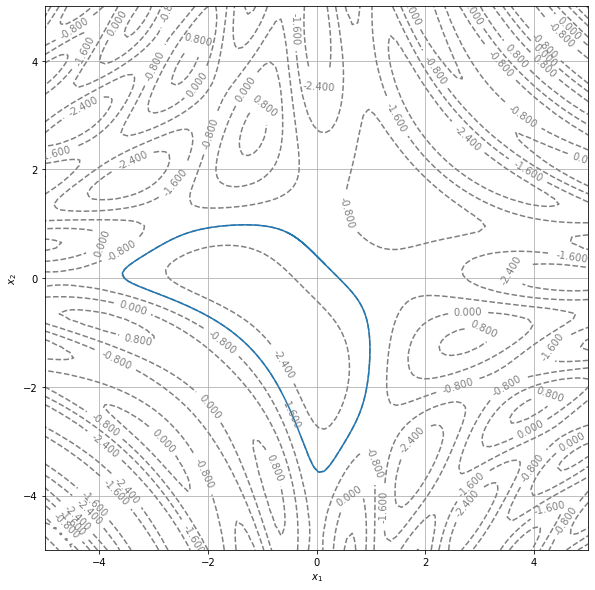

In [105]:
def graph_level(f, x, y, delta, Nb_pt, eps):
    display(f)
    L,M=level_curve(f, x, y, delta, Nb_pt, eps)[0],level_curve(f, x, y, delta, Nb_pt, eps)[1]
    plt.plot(L,M)
    plt.show()
    
graph_level(f1, x0, y0, 0.1, 60, eps)
graph_level(f2, x1, y1, 0.1, 100, eps)
graph_level(f3, x2, y2, 0.1, 150, eps)

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

**_Réponse 7_**

Soient deux segments $[s_k,s_{k+1}]$ et $[s_i,s_{i+1}]$ dont on cherche à savoir s'ils se recoupent. \
On considère les droites portées par chacun des segments, que l'on peut exprimer respectivement par $\{s_k + t(s_{k+1}-s_k), t \in \mathbb{R}\}$ et $\{s_i + t(s_{i+1}-s_i), t \in \mathbb{R}\}$.
Ainsi, pour trouver, si elle existe, l'intersection entre les deux droites on résout le système suivant:\
$$s_k + t_1(s_{k+1}-s_k) = s_i + t_2(s_{i+1}-s_i)$$ \
En notant $$s_j=\begin{pmatrix} x_j \\ y_j \end{pmatrix}$$
Le système se réecrit matriciellement:
$$\begin{pmatrix}(x_{k+1}-x_k)\  -(x_{i+1}-x_i)\\ (y_{k+1}-y_k)\  -(y_{i+1}-y_i)\end{pmatrix}.\begin{pmatrix} t_1 \\ t_2 \end{pmatrix}=\begin{pmatrix}x_i-x_k\\ y_i-y_k \end{pmatrix}$$ \
Il suffit alors de résoudre le système et de vérifier si les solutions vérifient $(t_1,t_2)\in[0,1]^2$.
Le cas où il y a plus d'un point d'intersection (donc où les segments sont au moins partiellement confondus) est suffisamment rare pour que l'on puisse l'ignorer dans la résolution.


Il est peu pertinent d'étudier des fonctions présentant des cas pathologiques comme celui illustré par la fonction de Rosenbrooke, car à l'endroit d'intersection de la ligne de niveau avec elle-même le gradient de la fonction est alors nul ce qui nous empêche d'appliquer la méthode de Newton lors de la construction de l'ensemble de niveau.

In [74]:
def not_intersect(seg1: 'segment 1', seg2: 'segment 2'):

    '''
    Renvoie True si les segments ne se coupent pas(ou s'ils sont confondus) et False s'il se coupent 
    Les segments sont de la forme [(L[0],M[0]),(L[1],M[1])]

    '''
    
    v0 = [seg1[1][0] - seg1[0][0], seg1[1][1] - seg1[0][1]]       #v0=s_(k+1)-s_k
    v1 = [(seg2[1][0] - seg2[0][0]), (seg2[1][1] - seg2[0][1])]   #v1=s_(i+1)-s_i
    v_1 = [(-1)*(seg2[1][0] - seg2[0][0]), (-1)*(seg2[1][1] - seg2[0][1])]  # -vecteur directeur2
    M = np.array([v0,v_1]).T
    B = np.array([[seg2[0][0] - seg1[0][0]],[seg2[0][1] - seg1[0][1]]])
    if np.linalg.det(M):
        x = np.linalg.solve(M,B)
        return not( x[0]>0 and x[0]<1 and x[1]>0 and x[1]<1 )
    return True  

def level_curve2(f, x0, y0, delta,  eps):
    L=np.array([[x0,y0]])
    g_new=g_f(f,L[0][0],L[0][1],delta)
    l,m=Newton(g_new, L[-1][0]+10e-2, L[-1][1]+10e-2, eps=eps, N=N)    #On calcule le premier segment
    L=np.concatenate((L,np.array([[l,m]])))
    seg1=[(L[0][0],L[0][1]),(L[-1][0],L[-1][1])] 
    seg=[(0,0),(0,0)]
    i=0 
    while not_intersect(seg1,seg) and i<500:
        g_new=g_f(f,L[-1][0],L[-1][1],delta)
        uf = u(f,L[-1][0],L[-1][1])
        l,m=Newton(g_new, L[-1][0]+delta*uf[0], L[-1][1]+delta*uf[1], eps, N) 
        L=np.concatenate((L,np.array([[l,m]])))
        seg=[(L[-2][0],L[-2][1]),(L[-1][0],L[-1][1])]
        i+=1
    if i == 500:
        return "error"                    #On prévoit un cas d'erreur si le nombre d'itérations est trop important
    return L.T

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

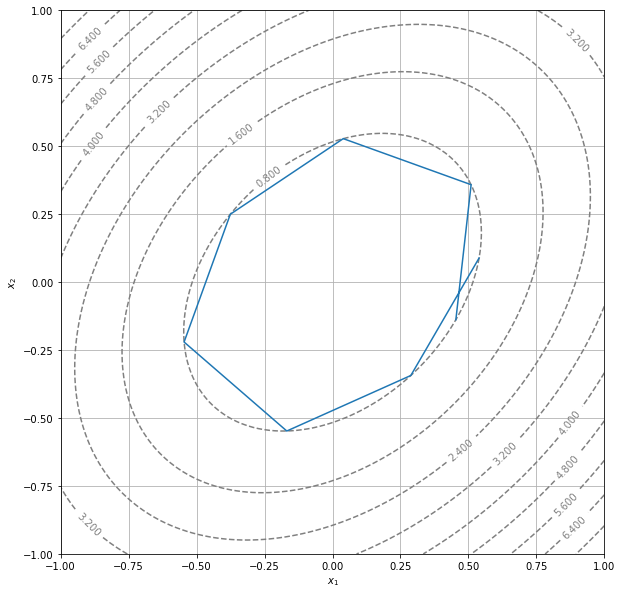

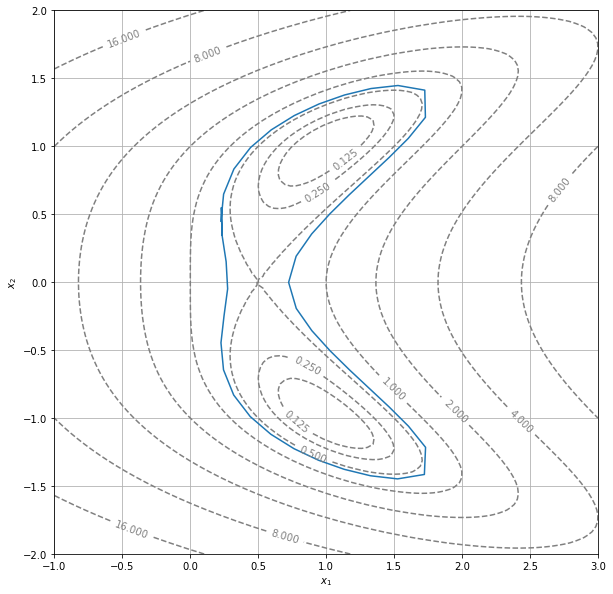

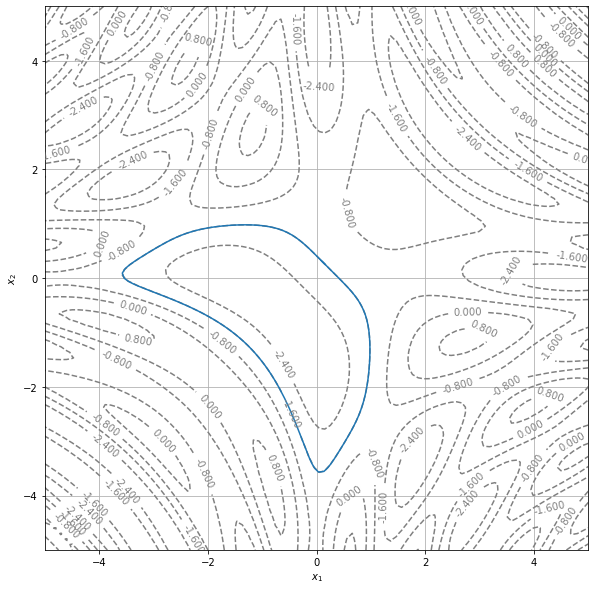

In [88]:
def graph_level2(f, x0, y0, delta, eps):
    display(f)
    L, M=level_curve2(f, x0, y0, delta, eps)[0], level_curve2(f, x0, y0, delta, eps)[1]
    plt.plot(L,M)
    plt.show()

graph_level2(f1, x0, y0, 0.5, eps)
graph_level2(f2, x1, y1, 0.2, eps)
graph_level2(f3, x2, y2, 0.1, eps)

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

**_Réponse 8_**

On note $u_1=(u_{1x},u_{1y}), u_2=(u_{2x},u_{2y}), P_1=(P_{1x},P_{1y})$ et $P_2=(P_{2x},P_{2y})$ \
On a $\gamma'(t)=(b+2ct,e+2ft)$ \
Les conditions en $t=0$ et $t=1$ donnent: 
$$(b,e)=\lambda u_1$$ 
$$(b+2c,e+2f)=\mu u_2, (\lambda,\mu)\in\mathbb{(R_+)^2}$$ 
$$(a,d)=P_1 $$ 
$$(a+b+c,d+e+f)=P_2$$ 

A partir de ce système à 8 equations on peut exprimer simplement les paramètres en fonctions des données initiales: 

$$\begin{pmatrix}a\\b\\c\\d\\e\\f\end{pmatrix}=\begin{pmatrix}P_{1x}\\\lambda u_{1x}\\\frac{1}{2}(\mu u_{2x}-\lambda u_{1x})\\P_{1y}\\\lambda u_{1y}\\\frac{1}{2}(\mu u_{2y}-\lambda u_{1y})\end{pmatrix}$$ 

D'où, par opérations élémentaires, le système suivant: 
$$P_2-P_1=\frac{1}{2}\begin{pmatrix}u_{1x}&u_{2x}\\u_{1y}&u_{2y}\end{pmatrix}\begin{pmatrix}\lambda\\\mu\end{pmatrix}$$
Dans le cas où la famille $(u_1,u_2)$ est libre, il existe une unique solution mais il faut vérifier si celle-ci est positive. \
Si $(u_1,u_2)$ est liée, on ne trouve de solutions que si $P_2-P_1$, $u_1$ et $u_2$ sont colinéaires de même sens. Cette solution correspond à un chemin rectiligne entre $P_1$ et $P_2$

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [80]:
def gamma (t: np.array,P1,P2,u1: np.array,u2):
    '''
    u1/P1= [u1x,u1y], renvoie un tableau [x0,x1,
                                          y0,y1]

    '''
    U = np.array([u1,u2]).T
    P=2*np.array([[P2[0]-P1[0]], [P2[1]-P1[1]]])
    if np.linalg.det(U):
        X=np.linalg.solve(U,P)
        if X.all()>0:                                        #Condition lambda et mu positifs
            l, m = X[0], X[1]
            a = P1[0]
            b = l*u1[0]
            c = 0.5*(m*u2[0] - l*u1[0])
            d = P1[1]
            e = l*u1[1]
            f = 0.5*(m*u2[1] - l*u1[1])
        return np.concatenate((a + b*t +c*t*t, d + e*t + f*t*t)).reshape(2,len(t))
    P1 = P1.T
    P2 = P2.T
    return P1 + (P2-P1)*t

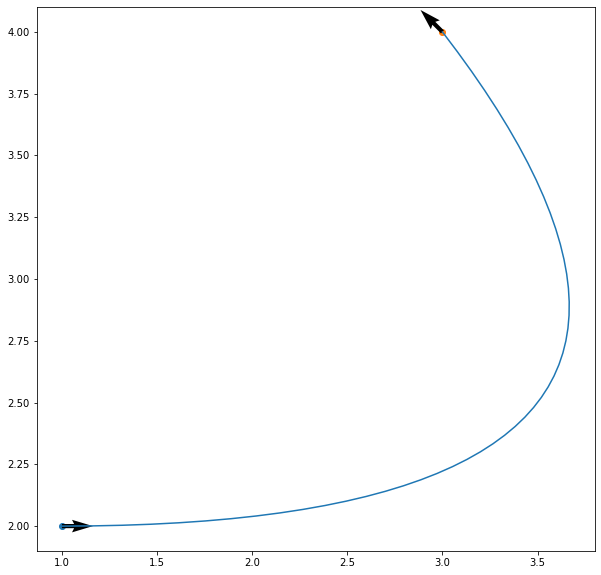

In [81]:
P1 = [1.0,2.0]
P2 = [3.0,4.0]
u1 = [1.0, 0.0]
u2 = [-1.0, 1.0]
E = np.linspace(0.0, 1.0, 50)
G = gamma(E,P1,P2,u1,u2)
plt.plot(G[0], G[1])
plt.scatter(P1[0], P1[1])
plt.scatter(P2[0],P2[1])
plt.quiver (P1[0], P1[1],u1[0],u1[1])
plt.quiver (P2[0], P2[1],u2[0],u2[1])
plt.show()

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [78]:
def level_curve3(f, x0, y0, delta,  eps, oversampling: int):
    L=np.array([[x0,y0]])
    g_new=g_f(f,L[0][0],L[0][1],delta)
    l,m=Newton(g_new, L[-1][0]+10e-2, L[-1][1]+10e-2, eps=eps, N=N)
    L=np.concatenate((L,np.array([[l,m]])))
    seg1=[(L[0][0],L[0][1]),(L[-1][0],L[-1][1])] #segment 1
    seg=[(0,0),(0,0)]
    i=0
    while not_intersect(seg1,seg) and i<1000:
        g_new=g_f(f,L[-1][0],L[-1][1],delta)
        uf = u(f,L[-1][0],L[-1][1])
        l,m=Newton(g_new, L[-1][0]+delta*uf[0], L[-1][1]+delta*uf[1], eps, N) 
        seg =  [(L[-1][0],L[-1][1]),(l,m)]
        E = np.linspace(0.0, 1.0, oversampling-1)
        u1 = u(f,L[-1][0],L[-1][1])
        u2 = u(f,l,m)
        G = gamma (E,L[-1],[l,m],u1,u2).T
        L = np.concatenate((L,G))
        L=np.concatenate((L,np.array([[l,m]])))
        
        i+=1
    if i == 1000:
        return "error"
    return L.T

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

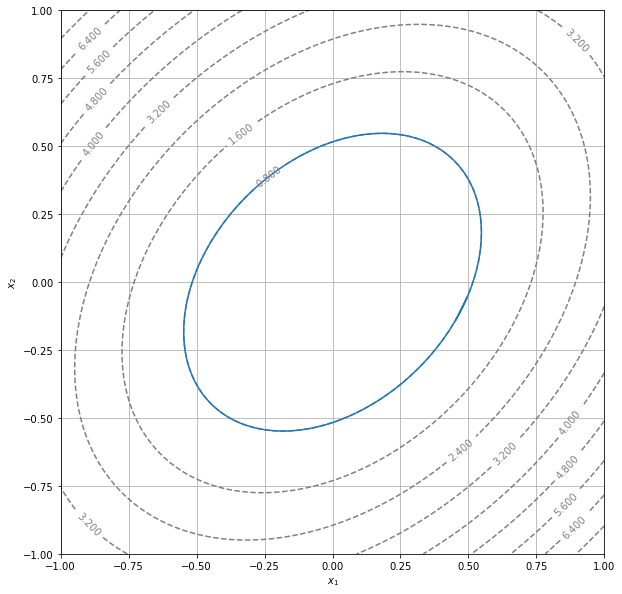

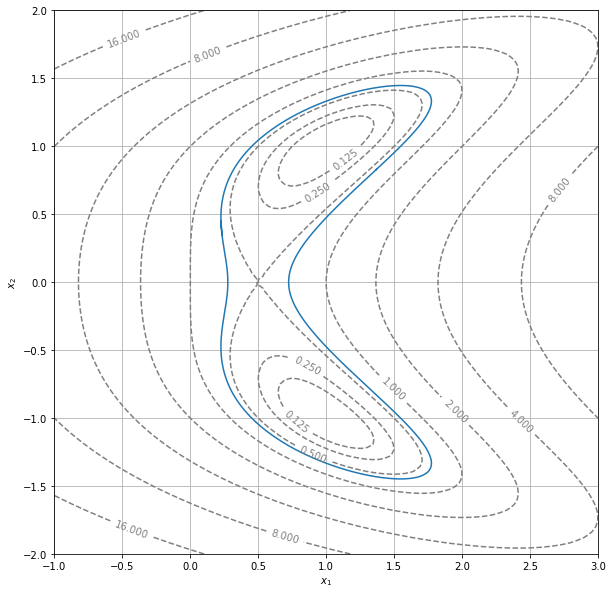

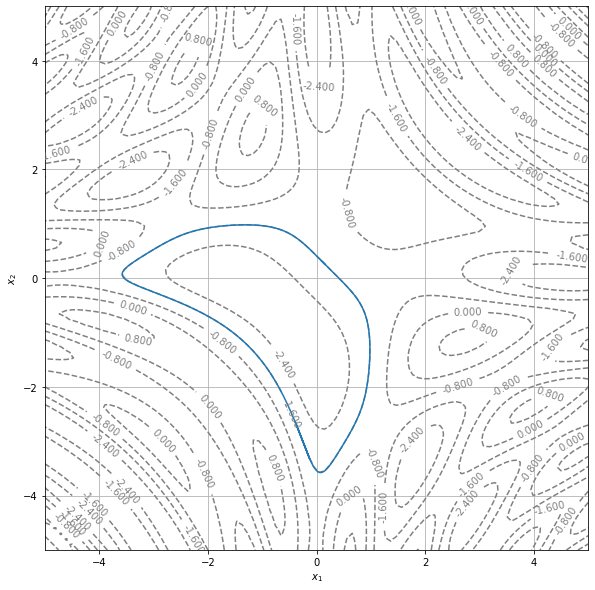

In [79]:
def graph_level3(f, x0, y0, delta, eps, oversampling):
    display(f)
    L, M=level_curve3(f, x0, y0, delta, eps,oversampling)[0], level_curve3(f, x0, y0, delta, eps, oversampling)[1]
    plt.plot(L,M)
    plt.show()

graph_level3(f1, x0, y0, 0.1, eps, 10)
graph_level3(f2, x1, y1, 0.1, eps, 10)
graph_level3(f3 , x2, y2, 0.1, eps, 10)